# Preprocessing data

The following notebook processes fMRI data.

## Imports

In [1]:
from decker.utils.io.io import BIDSio, parse_pdb
import pandas as pd
import numpy as np
from decker.analysis.utils.utils import nilearn_mask_single_data, nilearn_mask_group_by_condition
import os
import matplotlib.pyplot as plt
import nibabel as nib

#### Importing data

`decker.utils.io.io` contains a class, `BIDSio` created to handle the project's data in BIDS format. There is also a conda environment dedicated to just this procedure.

You only need to **run once!**

In [ ]:
# !wget # add .yml
# !conda create -f bidsio.yml
!conda activate bidio

Get the data to the environment by showing `BIDSio` where the BIDS root is.

In [3]:
bids_root = "/data/jdecke5/projects/honors-thesis/data/bids"
bids = BIDSio(bids_path=bids_root)

# bind bids_root to BIDSio
bids.init()

BIDSio(bids_path='/data/jdecke5/projects/honors-thesis/data/bids')

Display some information about the BIDS dataset.

In [4]:
bids.info()

Subjects: 
	 ['SL001', 'SL002', 'SL003', 'SL004', 'SL005', 'SL006', 'SL007', 'SL008', 'SL009', 'SL010', 'SL011', 'SL012', 'SL013', 'SL014', 'SL015', 'SL016', 'SL017', 'SL018', 'SL019']

Total subjects: 
	 19

Tasks: 
	 ['rest', 'statlearning']

Total tasks: 
	 2



Get list of functional data.

In [5]:
data = bids.get_func(task='statlearning', suffix="bold")
data

['/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL001/func/sub-SL001_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL002/func/sub-SL002_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL003/func/sub-SL003_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL004/func/sub-SL004_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL005/func/sub-SL005_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projects/honors-thesis/data/bids/derivatives/sub-SL006/func/sub-SL006_task-statlearning_space-MNI152NLin2009cAsym_res-2_desc-preproc_bold.nii.gz',
 '/data/jdecke5/projec

Because we need to jump between `conda environments` and scripts save, the list of files to a `.csv` or whatever file. 

In [6]:
out = "/data/jdecke5/projects/honors-thesis/data"
df = pd.DataFrame(data={"files": data}).to_csv(f"{out}/pps.csv")

## Importing participant database

`decker.utils.io.io` contains a function, `parse_pdb()`, which reads a file (either .xlsx or .csv) and transposes it based on a factor. So in this case, it transposes our data from wide to long by the conditions each participant belongs to.

In [7]:
db = "/data/jdecke5/projects/honors-thesis/data/participant_database.xlsx"
pps = parse_pdb(path=db, subid_col="Subject ID", cond_col="COND")

Let's see what this looks like.

In [8]:
pps

{'S': ['SL001',
  'SL003',
  'SL004',
  'SL007',
  'SL009',
  'SL011',
  'SL013',
  'SL015',
  'SL017',
  'SL019'],
 'R': ['SL002',
  'SL005',
  'SL006',
  'SL008',
  'SL010',
  'SL012',
  'SL014',
  'SL016',
  'SL018']}

You can see now that the subject IDs of each participant have been grouped by which condition they are in.

## Masking data

This uses some functionality from `decker.analysis.utils.utils`.

Demonstrating on one subject

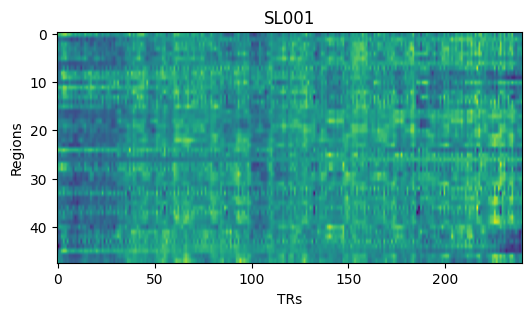

In [9]:
roidat, labels, report = nilearn_mask_single_data(atlas="cort-maxprob-thr25-1mm", file=data[0], report=True, plot=True)
report

Now let's do this for all subjects and parse the data by condition

In [10]:
roidata = nilearn_mask_group_by_condition(cond=pps, atlas="cort-maxprob-thr25-1mm", files=data)

Beginning masking procedure...
------------------------------

Masking: SL001 and adding to group: S 

Masking: SL003 and adding to group: S 

Masking: SL004 and adding to group: S 

Masking: SL007 and adding to group: S 

Masking: SL009 and adding to group: S 

Masking: SL011 and adding to group: S 

Masking: SL013 and adding to group: S 

Masking: SL015 and adding to group: S 

Masking: SL017 and adding to group: S 

Masking: SL019 and adding to group: S 

Masking: SL002 and adding to group: R 

Masking: SL005 and adding to group: R 

Masking: SL006 and adding to group: R 

Masking: SL008 and adding to group: R 

Masking: SL010 and adding to group: R 

Masking: SL012 and adding to group: R 

Masking: SL014 and adding to group: R 

Masking: SL016 and adding to group: R 

Masking: SL018 and adding to group: R 

------------------------------

Done!


Let's save this data so we can use it for later.

In [12]:
eventseg_dir = "/data/jdecke5/projects/honors-thesis/data/eventseg"
np.save(os.path.join(eventseg_dir, 'masked_data.npy'), roidata)

# now let's save one for each group
np.save(os.path.join(eventseg_dir, 'struc_masked_data.npy'), roidata["S"]) # structured
np.save(os.path.join(eventseg_dir, 'rand_masked_data.npy'), roidata["R"]) # random

Let's also save the labels

In [13]:
labels = {"labels": labels[1:]}
labels = pd.DataFrame(data=labels)
labels.to_csv(os.path.join(eventseg_dir, 'labels.csv'))